In [1]:
using DataFrames,PythonPlot,StatsBase,Random,Distributions,CSV
using GLMakie
PythonPlot.svg(true)
include("model.jl")

FIG_PATH = "/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

"/Users/elevien/Dropbox (Dartmouth College)/Apps/Overleaf/cell_cycle_growth/figures"

# Plot of cell-size trajectories

In [2]:
d = 2
A = [-1.0 0.0; 0.0 -1.0]
Γ = [0.1 0.0; 0.0 0.0]
uz = [1.0,0.0]
uθ = zeros(2)
b̃θ = zeros(2)
Cθ = zeros(2,2)
bz =[-1.0,0.0]
init = [0.0, 0.0, 0.0, 0.0]
dt = 0.01
T = 1000
ν0 = 1.0

params = (A,bz,b̃θ,uz,uθ,Cθ,Γ,ν0)
init = [0.0, 0.1, 0.0, 0.03]
dt = 0.01
T =50
df = make_sim_df(init, params, dt, T);
df.y = df.z .+ df.θ*log(2);

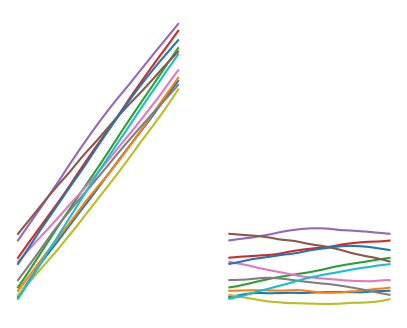

In [5]:
fig,axs = subplots(figsize=(5,4),ncols=2,sharey=true)

ax = axs[0]
for i in unique(df.cell)[10:20]
    d = df[df.cell .== i,:]
    #ax.plot(d.time,exp.(d.Z + log(2)*d.θ),"C0")
    ax.plot(d.θ,d.y)
end



ax = axs[1]
for i in unique(df.cell)[10:20]
    d = df[df.cell .== i,:]
    #ax.plot(d.time,exp.(d.Z + log(2)*d.θ),"C0")
    ax.plot(d.θ,d.z)
end

for ax in axs
    ax.get_xaxis().set_visible(false)
    ax.get_yaxis().set_visible(false)
    for spine in ["top", "bottom", "left", "right"]
        ax.spines[spine].set_visible(false)
    end
end

savefig(joinpath(FIG_PATH, "Fig1_cylinder.pdf"), bbox_inches="tight", pad_inches=0.3, format="pdf")

fig

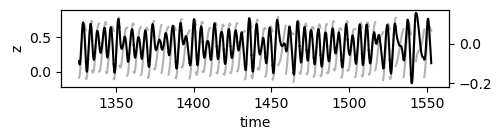

In [6]:
ν0 = log(2)
dt = 0.01
T = 2000

uz = 1.
by = -1.1


uθ = 0.1
bθ = 0.9

# run
uz = [uz,0.0]
by = [by,0.0]
uθ= [-0.9,0.0]
b̃θ= [-0.2,0.0]
Cθ = zeros((2,2))
A = [-0.2 0.0; 0.0 -1.0]
Γ = zeros((2,2))
Γ[1,1] = 0.02
params = (A,by,b̃θ,uz,uθ,Cθ, Γ,ν0)
init = [0.1, 0.0, -0.1, 0.0]

# Generate simulation dataframe
df = make_sim_df(init, params, dt, T);
df.y = df.z .+ log(2) .*df.θ
#df = df[df.time .> 10.0,:]

fig,ax = subplots(figsize=(5,1))
#ax[0].plot(df.time,df.z,"k--")

# for cell in unique(df.cell)[300:310]
#     df_cell = df[df.cell .== cell,:]
#     ax[0].plot(df_cell.time,df_cell.y,"-",label=string(cell))
#     ax[0].plot(df_cell.time,df_cell.x1,"-",label=string(cell))
# end
#ax[0].set_ylim([-0.1,2])
axt = ax.twinx()
for cell in unique(df.cell)[300:350]
    df_cell = df[df.cell .== cell,:]
    ax.plot(df_cell.time,df_cell.y,"k-",alpha=0.3)
    axt.plot(df_cell.time,df_cell.z,"k-")
end


ax.set_xlabel("time")
ax.set_ylabel("z")
#ax[1].set_ylim([-5,5])
fig

# Experimental data

In [7]:
# make dataframe from CSV file
include("./process_mm_data.jl")
DATA_PATH = "./data/MC4100_25C"
data = [CSV.read(DATA_PATH*"/"*f,DataFrame,header=string.(["row","div","length","x","z"])) for f in readdir(DATA_PATH)]
data = vcat([hcat(data[i],DataFrame(:lineage=>i*ones(length(data[i][:,1])))) for i in eachindex(data)]...)
data = combine(groupby(data,:lineage),:div => cumsum => :n,names(data));


# Apply the function to each lineage and concatenate results
data = vcat([process_lineage(c) for c in groupby(data, :lineage)]...);
data.z = data.Y .- data.T .* log(2);
#data = data[data.lineage .==3,:]
dfcell = combine(groupby(data,[:lineage,:cell]),:z => (x -> x[1])=>:z0, 
    :Y => (x -> x[end] - x[1])=>:ϕ,
    :time => (x -> x[end]-x[1])=>:τ);
dfcell.λ = dfcell.ϕ ./ dfcell.τ ;
data.time = data.time .* mean(dfcell.λ)
data. τ = data.time .* mean(dfcell.λ)
dfcell.λ = dfcell.λ ./ mean(dfcell.λ)
dfcell.τ = dfcell.τ .* mean(dfcell.λ);
dfcell.λ = (dfcell.λ  .- mean(dfcell.λ)) ./ std(dfcell.λ);
dfcell.τ = (dfcell.τ  .- mean(dfcell.τ)) ./ std(dfcell.τ);

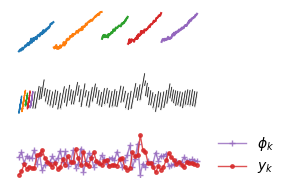

In [8]:
fig,axs = subplots(figsize=(3,2),nrows = 3)

ax = axs[0]
df = data[data.lineage .== 3,:]
for i in unique(df.cell)[1:5]
    d = df[df.cell .== i,:]
    ax.plot(d.τ,d.Y)
    ax.axis("off")
end

ax = axs[1]

for i in unique(df.cell)[1:5]
    d = df[df.cell .== i,:]
    ax.plot(d.τ,d.Y,lw=1)
    ax.axis("off")
end

for i in unique(df.cell)[6:end]
    d = df[df.cell .== i,:]
    ax.plot(d.τ,d.Y,"k-",alpha=0.1,lw=1)
    #ax.plot([d.τ[1],d.τ[end]],[d.z[1],d.z[1]],"C3-",lw=1)
    ax.plot([d.τ[1],d.τ[end]],[d.z[1],d.Y[end]],"k-",lw=0.5)
    
    ax.axis("off")
end
ax = axs[2]
ax.axis("off")
ax.plot(dfcell[dfcell.lineage .==3,:].ϕ,"C4+-",label=L"$\phi_k$",lw=1.,markersize=5,alpha=0.8)
ax.plot(dfcell[dfcell.lineage .==3,:].z0,"C3.-",label=L"$y_k$",lw=1.,markersize=5,alpha=0.8)
# make legend to right of plot
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=false)
tight_layout()
savefig(joinpath(FIG_PATH, "data_coarse_graining.pdf"), bbox_inches="tight")
fig

In [ ]:


# Parameters
ρ₀ = 0.0
ν₀ = 1.0
c = -1.2
b = 1.0
d = 1.3
e = -2.

# Simulation parameters
dt = 0.01
T = 500.0
steps = Int(T/dt)

# Initialize arrays
z = zeros(steps)
θ = zeros(steps)
t = range(0, length=steps, step=dt)

# Initial conditions
z[1] = 1.0
θ[1] = 0.25

# Euler integration loop
for i in 1:steps-1
    dz = ρ₀ + c * z[i] + b * θ[i]
    dθ = ν₀ + d * z[i] + e * θ[i]
    
    z[i+1] = z[i] + dt * dz
    θ[i+1] = mod(θ[i] + dt * dθ, 1.0)  # wrap θ to [0, 1)
end

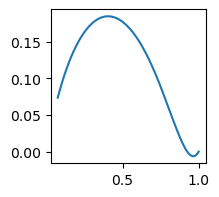

In [33]:
fig,ax = subplots(figsize=(2,2))
ax.plot(z .*sin.(2π*θ),z .*cos.(2π*θ),"-")
fig

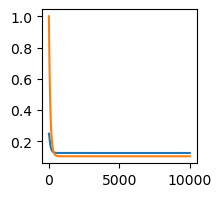

In [34]:
fig,ax = subplots(figsize=(2,2))
ax.plot(θ,"-")
ax.plot(z,"-")
fig